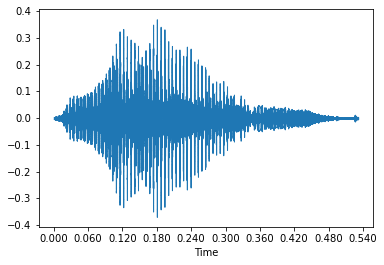

In [1]:

import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings

from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

file_name = 'D:\Projects\BiGRU\\recordings\\1_george_3.wav'

audio_data, sampling_rate = librosa.load(file_name)
librosa.display.waveshow(audio_data, sr=sampling_rate)
ipd.Audio(file_name)

In [2]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=150)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    return mfccs_scaled_features

In [3]:
extracted_features = []

dataset_dir = "D:\Projects\BiGRU\\recordings"
for filename in os.listdir(dataset_dir):
    class_label = filename[0]
    data = features_extractor(dataset_dir + "\\" + filename)
    extracted_features.append([data, class_label])

In [4]:
extracted_features_df = pd.DataFrame(extracted_features, columns=['feature', 'class'])
extracted_features_df

,feature,class
0,"[-319.8768, 163.10466, -79.28479, 37.59662, 53...",0
1,"[-385.89505, 170.73756, -53.566486, 13.352422,...",0
2,"[-430.8307, 132.19684, -49.897274, 9.455913, 3...",0
3,"[-396.8455, 171.49179, -74.900635, 15.270986, ...",0
4,"[-395.99686, 174.60915, -72.94622, 13.372607, ...",0
...,...,...
2995,"[-547.53894, 233.48476, -61.823864, -8.623617,...",9
2996,"[-498.78867, 233.19414, -83.00762, -8.217661, ...",9
2997,"[-519.4446, 220.43921, -70.72736, -9.120728, 2...",9
2998,"[-567.8524, 238.0549, -65.34116, -2.844866, 25...",9


In [5]:
from keras.utils import to_categorical

X = np.array(extracted_features_df['feature'].tolist()).reshape((3000, 128, 1))
y = np.array(extracted_features_df['class'].tolist())
y = to_categorical(y)

Using TensorFlow backend.


In [6]:
X.shape

(3000, 128, 1)

In [7]:
y.shape

(3000, 10)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
num_classes = len(np.unique(y_train))
print(X_val[0].shape)

(128, 1)


In [31]:
from tensorflow.keras import *

model_gru = Sequential([
    Input(shape=(128, 1)),
    layers.Activation("sigmoid"),
    layers.Bidirectional(layers.GRU(units=40, activation='tanh', dropout=0.1)),
    layers.Dense(40, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_gru.build()
model_gru.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)
model_gru.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_5 (Activation)    (None, 128, 1)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80)                10080     
_________________________________________________________________
dense_10 (Dense)             (None, 40)                3240      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                410       
Total params: 13,730
Trainable params: 13,730
Non-trainable params: 0
_________________________________________________________________


In [32]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'acc',
    patience = 15)
    history = model.fit(X_train, y_train, epochs=500,
                        validation_split=0.2,
                        batch_size=75, shuffle=False,
    callbacks = [early_stop])
    return history


history_gru = fit_model(model_gru)


Train on 2160 samples, validate on 540 samples
Epoch 1/500
2160/2160 [==============================] - 9s 4ms/sample - loss: 2.3024 - acc: 0.1032 - val_loss: 2.3045 - val_acc: 0.0926
Epoch 2/500
2160/2160 [==============================] - 8s 4ms/sample - loss: 2.3004 - acc: 0.0977 - val_loss: 2.3029 - val_acc: 0.0889
Epoch 3/500
2160/2160 [==============================] - 8s 4ms/sample - loss: 2.2972 - acc: 0.1227 - val_loss: 2.3004 - val_acc: 0.1111
Epoch 4/500
2160/2160 [==============================] - 8s 4ms/sample - loss: 2.2922 - acc: 0.1259 - val_loss: 2.2936 - val_acc: 0.1148
Epoch 5/500
2160/2160 [==============================] - 8s 4ms/sample - loss: 2.2632 - acc: 0.1606 - val_loss: 2.1796 - val_acc: 0.2407
Epoch 6/500
2160/2160 [==============================] - 8s 4ms/sample - loss: 2.1046 - acc: 0.2037 - val_loss: 2.0766 - val_acc: 0.1574
Epoch 7/500
2160/2160 [==============================] - 8s 4ms/sample - loss: 2.0230 - acc: 0.2398 - val_loss: 1.9415 - val_acc: 0

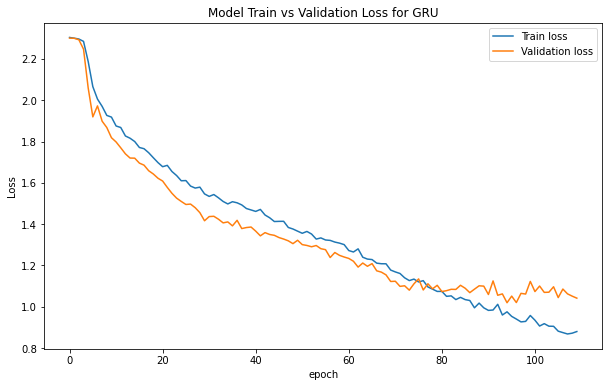

In [12]:
def plot_loss(history, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')


plot_loss(history_gru, 'GRU')

In [9]:
from tensorflow.keras import *
import tensorflow as tf
from tensorflow import keras

model_gru = Sequential([
    Input(shape=(128, 1)),
    layers.Activation("sigmoid"),
    layers.Bidirectional(layers.GRU(units=50, activation='tanh', dropout=0.1)),
    layers.Dense(40, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_gru.build()
model_gru.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)
model_gru.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation (Activation)      (None, 128, 1)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               15600     
_________________________________________________________________
dense (Dense)                (None, 40)                4040      
_________________________________________________________________
dense_1 (Dense)  

In [10]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'acc',
                                               patience = 15)
    history = model.fit(X_train, y_train, epochs=110,
                        validation_split=0.2,
                        batch_size=75, shuffle=False,
                        callbacks = [early_stop])
    return history


history_gru = fit_model(model_gru)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2160 samples, validate on 540 samples
Epoch 1/110
2160/2160 [==============================] - 15s 7ms/sample - loss: 2.3036 - acc: 0.0917 - val_loss: 2.3005 - val_acc: 0.1130
Epoch 2/110
2160/2160 [==============================] - 12s 6ms/sample - loss: 2.3002 - acc: 0.1204 - val_loss: 2.2997 - val_acc: 0.1130
Epoch 3/110
2160/2160 [==============================] - 13s 6ms/sample - loss: 2.2961 - acc: 0.1375 - val_loss: 2.2925 - val_acc: 0.1333
Epoch 4/110
2160/2160 [==============================] - 12s 6ms/sample - loss: 2.2846 - acc: 0.1477 - val_loss: 2.2469 - val_acc: 0.1944
Epoch 5/110
2160/2160 [==============================] - 12s 6ms/sample - loss: 2.1872 - acc: 0.1981 - val_loss: 2.0595 - val_acc: 0.2704
Epoch 6/110
2160/2160 [==============================] - 12s 6ms/sample - loss: 2.0655 - acc: 0.2306 - val_loss: 1.9192 - val_acc: 0.2981
Epoch 7/110
2160/2160 [========

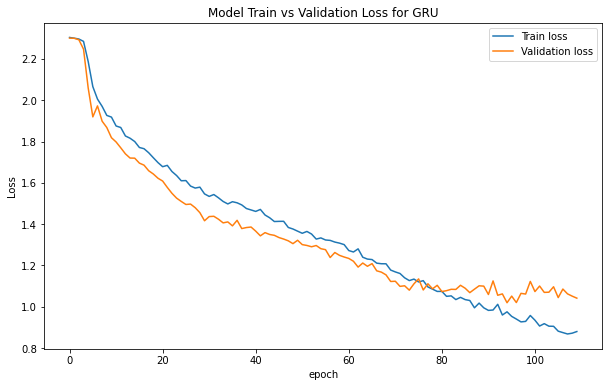

In [13]:
plot_loss(history_gru, 'GRU')

Predicted digit:  6


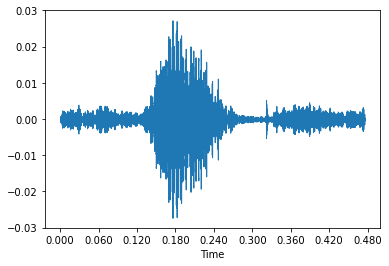

In [16]:
# Make prediction
file_name = 'D:\Projects\BiGRU\\recordings\\6_theo_4.wav'

data = features_extractor(file_name).reshape(1, 128, 1)

prediction = model_gru.predict(data, verbose=False)

print("Predicted digit: ", np.argmax(prediction))
audio_data, sampling_rate = librosa.load(file_name)
librosa.display.waveshow(audio_data, sr=sampling_rate)
ipd.Audio(file_name)

In [17]:

model_lstm = Sequential([
    Input(shape=(128, 1)),
    layers.Activation("sigmoid"),
    layers.LSTM(units=50, activation='tanh', dropout=0.1),
    layers.Dense(40, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_lstm.build()
model_lstm.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=['accuracy']
)
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
activation_1 (Activation)    (None, 128, 1)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                410       
Total params: 12,850
Trainable params: 12,850
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_lstm = fit_model(model_lstm)

Train on 2160 samples, validate on 540 samples
Epoch 1/110
2160/2160 [==============================] - 5s 2ms/sample - loss: 1.7574 - acc: 0.3375 - val_loss: 2.0293 - val_acc: 0.2407
Epoch 2/110
2160/2160 [==============================] - 5s 2ms/sample - loss: 1.7719 - acc: 0.3241 - val_loss: 1.8768 - val_acc: 0.2667
Epoch 3/110
2160/2160 [==============================] - 5s 2ms/sample - loss: 1.7896 - acc: 0.3069 - val_loss: 1.8875 - val_acc: 0.3037
Epoch 4/110
2160/2160 [==============================] - 5s 2ms/sample - loss: 1.7518 - acc: 0.3259 - val_loss: 1.8585 - val_acc: 0.2796
Epoch 5/110
2160/2160 [==============================] - 5s 2ms/sample - loss: 1.7151 - acc: 0.3532 - val_loss: 1.8291 - val_acc: 0.3315
Epoch 6/110
2160/2160 [==============================] - 5s 2ms/sample - loss: 1.6787 - acc: 0.3546 - val_loss: 1.9845 - val_acc: 0.2704
Epoch 7/110
2160/2160 [==============================] - 5s 2ms/sample - loss: 1.6846 - acc: 0.3542 - val_loss: 1.8699 - val_acc: 0

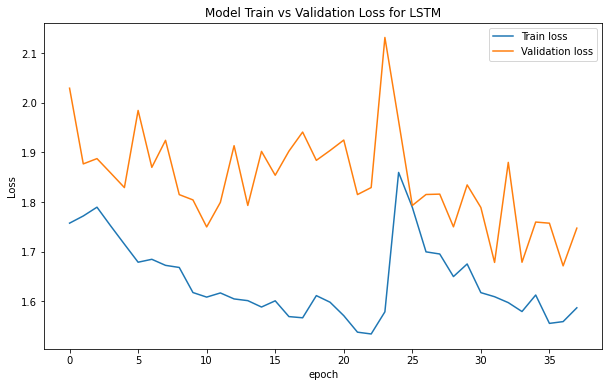

In [21]:
plot_loss(history_lstm, 'LSTM')